# 使用 BLIP-2 生成图片 Embedding

为了获取用于聚类的 Embedding，我们用 CIFAR-100 数据集作为图片来源，然后用 BLIP-2 模型生成图片的 Embedding。

Huggingface: [Salesforce/blip2-opt-2.7b](https://huggingface.co/Salesforce/blip2-opt-2.7b)

> **BLIP-2 (Bootstrapping Language-Image Pre-training 2)** 是 Salesforce 研究院于 2023 年提出的多模态模型。它由三部分组成：
> 
> - 图像编码器（类似 CLIP 的视觉模型）：用于提取图像特征
> - 查询变换器（Q-Former）：作为连接图像与文本的桥梁
> - 大型语言模型（LLM，如 OPT-2.7B）：用于生成文本 
> 
> BLIP-2 训练时，冻结图像编码器和大语言模型的参数，仅优化 Q-Former，这样既能充分利用已有的单模态能力，又能有效提升图文模型的交互效率。Q-Former 作为连接两个模态的桥梁，通过查询学习将视觉特征转换为与语言模型相兼容的表示，从而实现高效的跨模态对齐。

In [ ]:
import io
import os
import base64
import pickle
import requests
import numpy as np
import pandas as pd
import torch

import utils

from transformers import Blip2Processor, Blip2Model
from concurrent.futures import ThreadPoolExecutor
from typing import List, Optional
from PIL import Image
from IPython.display import display

CIFAR_PATH = 'data/cifar-100-python/'
API_URL = 'http://localhost:8210/embeddings/'
SAMPLE_NUM = 10000
CSV_PATH = './data'
MODEL_PATH = './model/blip2-opt-2.7b'

## 1. 下载 CIFAR-100 数据集

打开 CIFAR-100 数据集下载页 ( https://www.cs.toronto.edu/~kriz/cifar.html )，点击链接 [CIFAR-100 python version](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz) 下载数据集。

将压缩包 `cifar-100-python.tar.gz` 放在项目的 `./data` 路径下并解压：

```
cd data
tar -xvzf cifar-100-python.tar.gz
```

In [2]:
def load_cifar100_batch(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')

    # 解析数据
    images = data[b'data']
    labels = data[b'fine_labels']  # 细粒度标签（100类）

    # 转换图像格式（3072=32x32x3）
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return images, labels

def preprocess_image(image):
    # 若数据格式为 CHW（如 CIFAR-100），转为 HWC
    if image.shape[0] in (1, 3):  # 灰度图或 RGB 图
        image = image.transpose(1, 2, 0)
    # 若数据被归一化到 [0, 1]，还原为 [0, 255]
    if np.max(image) <= 1.0:
        image = (image * 255).astype(np.uint8)
    return image

def show_image(idx):
    if idx < len(train_images):
        image = train_images[idx]
        image = preprocess_image(image)
        display(Image.fromarray(image))
    else:
        print(f'max idx: {len(train_images) - 1}')

In [3]:
# 加载训练集和测试集
train_images, train_labels = load_cifar100_batch(os.path.join(CIFAR_PATH, 'train'))
test_images, test_labels = load_cifar100_batch(os.path.join(CIFAR_PATH, 'test'))

len(train_images), len(test_images)

(50000, 10000)

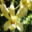

In [4]:
# 展示第 idx 张图片
show_image(idx=1231)

## 2. 下载 BLIP-2 模型文件

```
mkdir model

pip install -U huggingface_hub

export HF_ENDPOINT=https://hf-mirror.com
huggingface-cli download --resume-download Salesforce/blip2-opt-2.7b --local-dir ./model/blip2-opt-2.7b
```

## 3. 计算图片 Embedding

In [5]:
# 模型初始化
processor = Blip2Processor.from_pretrained(MODEL_PATH)
model = Blip2Model.from_pretrained(MODEL_PATH)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# 做简单的推理
image = train_images[0]
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model.get_image_features(**inputs)
    image_embedding = outputs.pooler_output
    # image_embedding = outputs.last_hidden_state[:, 0, :]

image_embedding.shape

torch.Size([1, 1408])

In [7]:
image_embedding

tensor([[ 1.0786, -1.5979,  1.6206,  ..., -0.4472,  0.1021, -0.2331]])

然后进阶一点，把推理步骤写成函数。

In [8]:
def get_image_embedding(image_path, device):
    # 加载 BLIP-2 模型和处理器
    processor = Blip2Processor.from_pretrained(MODEL_PATH)
    model = Blip2Model.from_pretrained(MODEL_PATH).to(device)

    # 加载和预处理图片
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 获取图片 embedding
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
        image_embedding = outputs.last_hidden_state

    return image_embedding

In [9]:
image_path = "./img/choice.jpg"
embedding = get_image_embedding(image_path, device="cpu")
embedding.shape

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1, 257, 1408])

In [10]:
embedding

tensor([[[ 0.0864, -0.1190, -0.0338,  ..., -0.5104, -0.9064,  0.1509],
         [-0.2842,  0.6082, -1.2617,  ...,  0.1604,  0.7182, -1.6816],
         [ 0.4250, -0.0169,  0.3701,  ...,  0.5225, -0.7994, -0.6521],
         ...,
         [ 0.4668,  0.3463, -0.3944,  ...,  0.4220,  0.3917,  0.1684],
         [ 0.6901,  0.2861,  0.0472,  ..., -0.0905, -1.6351, -1.6209],
         [-0.7165,  0.6343, -0.3295,  ...,  0.0269,  0.9396, -0.7667]]])

## 4. 验证 BLIP-2 服务端代码

基于 FastAPI 框架，开发 BLIP-2 Embedding 生成服务代码，该服务支持 GPU 批量推理 和 输出向量归一化。服务端代码见本仓库的 [/server/blip2_server.py](./server/blip2_server.py) 文件。

运行以下命令，启动 BLIP-2 推理服务：

```bash
cd server
python blip2_server.py
```

推理服务成功启动后，我们来验证服务端是否如预期运行。

以下代码将图片经 base64 编码后传给服务端，服务端接收图片，通过 BLIP-2 模型的正向传播计算，返回图片的 embedding。

In [11]:
API_URL = "http://localhost:8210/embeddings/"


def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string


def client(base64_images):
    response = requests.post(
        API_URL,
        json={
            "base64_images": base64_images,
            "normalize": True
        },
        timeout=30
    )
    response.raise_for_status()  # 触发 HTTP 错误状态异常
    return response.json()

In [12]:
image_paths = [
    './img/choice.jpg',
    './img/book.jpg'
]
base64_images = [image_to_base64(p) for p in image_paths]

result = client(base64_images)
embeddings = torch.Tensor(result['embeddings'])
norms = torch.norm(embeddings, p=2, dim=1)

print(f'embeddings.shape: {embeddings.shape}')
print(f'norms: {norms}')

embeddings.shape: torch.Size([2, 1408])
norms: tensor([1., 1.])


## 5. 开发 BLIP-2 客户端代码

开发一个客户端，多线程地请求 BLIP-2 接口，将 CIFAR-100 数据集中的图片转成 Embedding，并保存到 data 目录下的 csv 文件。

该开发流程在 [dec-pytorch](https://github.com/luochang212/dec-pytorch/blob/main/2.prepare_data.ipynb) 中亦有记载，就不详细展开了。这里将 `dec-pytorch` 的代码集成到 `utils.py` 直接调用。

In [5]:
train_embeddings = utils.gen_image_embed(images=train_images[:SAMPLE_NUM])

In [6]:
# 将 Embedding 和 label 存成 DataFrame
embed_df = pd.DataFrame({
    'embeddings': train_embeddings,
    'labels': train_labels[:SAMPLE_NUM]
})
embed_df.head()

,embeddings,labels
0,"[0.024523582309484482, -0.03633105754852295, 0...",19
1,"[-0.002521098591387272, 0.022899063304066658, ...",29
2,"[0.008400454185903072, -0.012612388469278812, ...",0
3,"[-0.004734962247312069, -0.0035224033053964376...",11
4,"[-0.021240245550870895, -0.03918471559882164, ...",1


In [7]:
# 将 DataFrame 存成 csv
embed_csv_path = os.path.join(CSV_PATH, 'embed_label.csv')
utils.embedding_df_to_csv(df=embed_df,
                          csv_path=embed_csv_path,
                          ebd_cols=['embeddings'])

In [8]:
# 将 csv 读入 DataFrame
embed_df = utils.read_embedding_csv(csv_path=embed_csv_path,
                                    ebd_cols=['embeddings'])
len(embed_df)

10000